# Sieci neuronowe i Deep Learning
# Temat 3: Wielowarstwowy perceptron i algorytm wstecznej propagacji błędu

W ramach poniższych zadań kontynuowali będziemy przykład budowy sieci MLP do rozpoznawania odręcznie napisanych cyfr (wstępnie omówiony na wykładzie z tematem 3).

## Zadanie 3.1

Przeanalizować implementację klasy
wielowarstwowego perceptronu (z jedną warstwą ukrytą, sigmoidalną funkcją aktywacji oraz średniokwadratową funkcją straty) oraz implementacje
funkcji
`minibatch_generator()`,
`mse_loss()`,
`accuracy()`,
`compute_mse_and_acc()`
oraz
`train()` (notebook do wykładu).

? Słownie moze cos trzeba wyjasnic

## Zadanie 3.2

Dla przykładu klasyfikacji cyfr utworzyć obiekt klasy `NeuralNetMLP` z 50 neuronami w warstwie ukrytej.

Poniższa grafika przedstawia szkicowo architekturę utworzonej sieci neuronowej.

Następnie przeprowadzić proces uczenia tego modelu przez 50 epok. Przyjąć `learning_rate=0.1`.

Obserwując jakość modelu w trakcie uczenia go, możemy wyłapać sytuację złego doboru hiperparametrów (niska jakość na zb. treningowym i walidacyjnym) lub przeuczenie modelu (duża rozbieżność pomiędzy jakością modelu na zbiorze treningowym a jakością na zbiorze walidacyjnym). Wówczas przerywamy proces uczenia.

Czy któryś z tych efektów jest widoczny w procesie uczenia z tego zadania?

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 78.88% | Valid Acc: 78.20%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.97% | Valid Acc: 85.68%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 88.09% | Valid Acc: 87.56%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.33% | Valid Acc: 88.80%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.12% | Valid Acc: 89.58%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.74% | Valid Acc: 90.42%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.19% | Valid Acc: 90.86%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.56% | Valid Acc: 91.18%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.87% | Valid Acc: 91.30%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.12% | Valid Acc: 91.46%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.35% | Valid Acc: 91.60%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.56% | Valid Acc: 91.70%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.76% | Valid Acc: 91.98%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.88

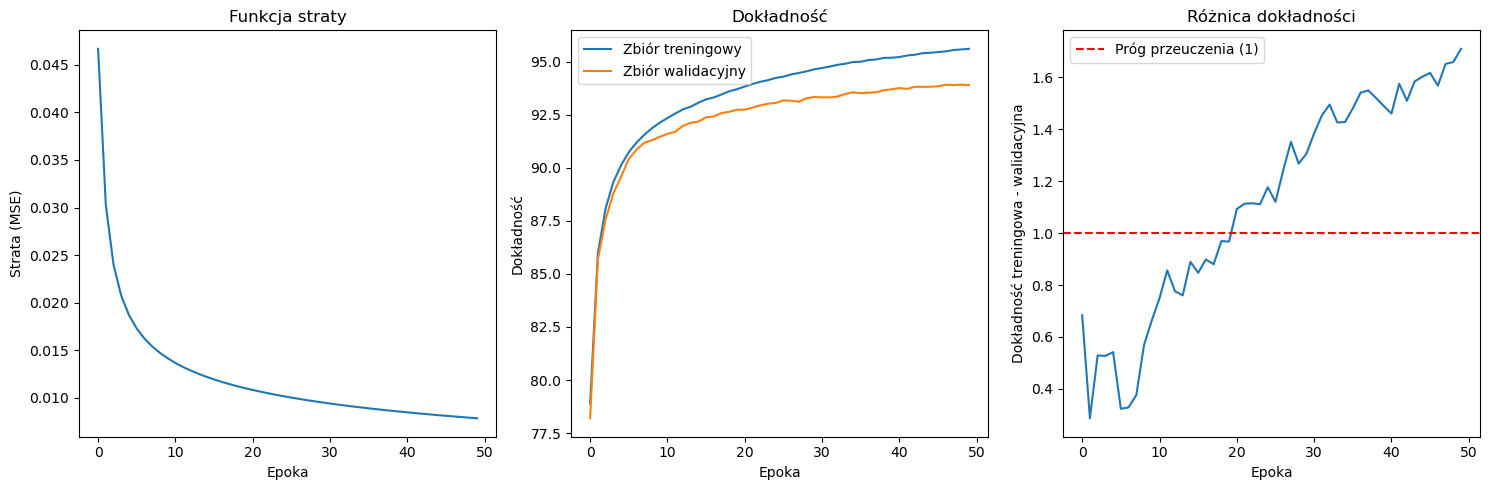

Końcowa dokładność treningowa: 95.6091
Końcowa dokładność walidacyjna: 93.9000
Różnica: 1.7091
Zaobserwowany efekt: Przeuczenie modelu


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Funkcje pomocnicze
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

# Poprawiona klasa NeuralNetMLP - dodajemy podkreślniki w funkcji init i poprawiamy nazwy zmiennych
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out 

        # gradient for output weights
        d_z_out__dw_out = a_h
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        # Part 2: dLoss/dHiddenWeights
        d_z_out__a_h = self.weight_out
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        d_z_h__d_w_h = x
        
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

# Wczytanie danych MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

# Podział danych na zbiory treningowy, walidacyjny i testowy
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Inicjalizacja modelu z 50 neuronami w warstwie ukrytej
num_features = X_train.shape[1]  # 784 dla MNIST
num_hidden = 50    # zgodnie z zadaniem
num_classes = 10   # cyfry 0-9

model = NeuralNetMLP(num_features=num_features, 
                    num_hidden=num_hidden, 
                    num_classes=num_classes)

# Funkcja do trenowania modelu
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1, minibatch_size=128):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

# Parametry uczenia
num_epochs = 50      # zgodnie z zadaniem
learning_rate = 0.1  # zgodnie z zadaniem
minibatch_size = 128

# Uruchomienie procesu uczenia
train_losses, train_accuracies, val_accuracies = train(
    model, X_train, y_train, X_val, y_val, 
    num_epochs=num_epochs, 
    learning_rate=learning_rate,
    minibatch_size=minibatch_size)

# Wizualizacja wyników
plt.figure(figsize=(15, 5))

# Wykres funkcji straty
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Funkcja straty')
plt.xlabel('Epoka')
plt.ylabel('Strata (MSE)')

# Wykres dokładności
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Zbiór treningowy')
plt.plot(val_accuracies, label='Zbiór walidacyjny')
plt.title('Dokładność')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

# Wykres różnicy między dokładnością treningową a walidacyjną
plt.subplot(1, 3, 3)
differences = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]
plt.plot(differences)
plt.axhline(y=1, color='r', linestyle='--', label='Próg przeuczenia (1)')
plt.title('Różnica dokładności')
plt.xlabel('Epoka')
plt.ylabel('Dokładność treningowa - walidacyjna')
plt.legend()

plt.tight_layout()
plt.show()

final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]
acc_diff = final_train_acc - final_val_acc

print(f"Końcowa dokładność treningowa: {final_train_acc:.4f}")
print(f"Końcowa dokładność walidacyjna: {final_val_acc:.4f}")
print(f"Różnica: {acc_diff:.4f}")

if final_train_acc < 0.7 and final_val_acc < 0.7:
    print("Zaobserwowany efekt: Zły dobór hiperparametrów (niska jakość na obu zbiorach)")
elif acc_diff > 0.1:
    print("Zaobserwowany efekt: Przeuczenie modelu")
else:
    print("Nie zaobserwowano znaczących problemów w procesie uczenia")

## Zadanie 3.4*

Na koniec ocenić zbudowany model pod kątem jego generalizacji na nowe dane. Obliczyć jego dokładność na zbiorze testowym (MSE oraz dokładność). Nie douczać modelu na danych ze zbioru walidacyjnego.

In [18]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print("\nWyniki na zbiorze testowym:")
print(f"MSE: {test_mse:.4f}")
print(f"Dokładność: {test_acc*100:.2f}%")



Wyniki na zbiorze testowym:
MSE: 0.0097
Dokładność: 94.29%


## Zadanie 3.5*

Wyświetlić 25 pierwszych przykładów ze zbioru testowego, które zostały błędnie sklasyfikowane.

In [19]:
def find_misclassified_examples(model, X, y, max_count=25):
    _, probas = model.forward(X)
    predicted_labels = np.argmax(probas, axis=1)
    
    misclassified_indices = np.where(predicted_labels != y)[0]
    
    return misclassified_indices[:max_count], predicted_labels[misclassified_indices[:max_count]], y[misclassified_indices[:max_count]]

misclassified_indices, predicted_labels, true_labels = find_misclassified_examples(model, X_test, y_test)

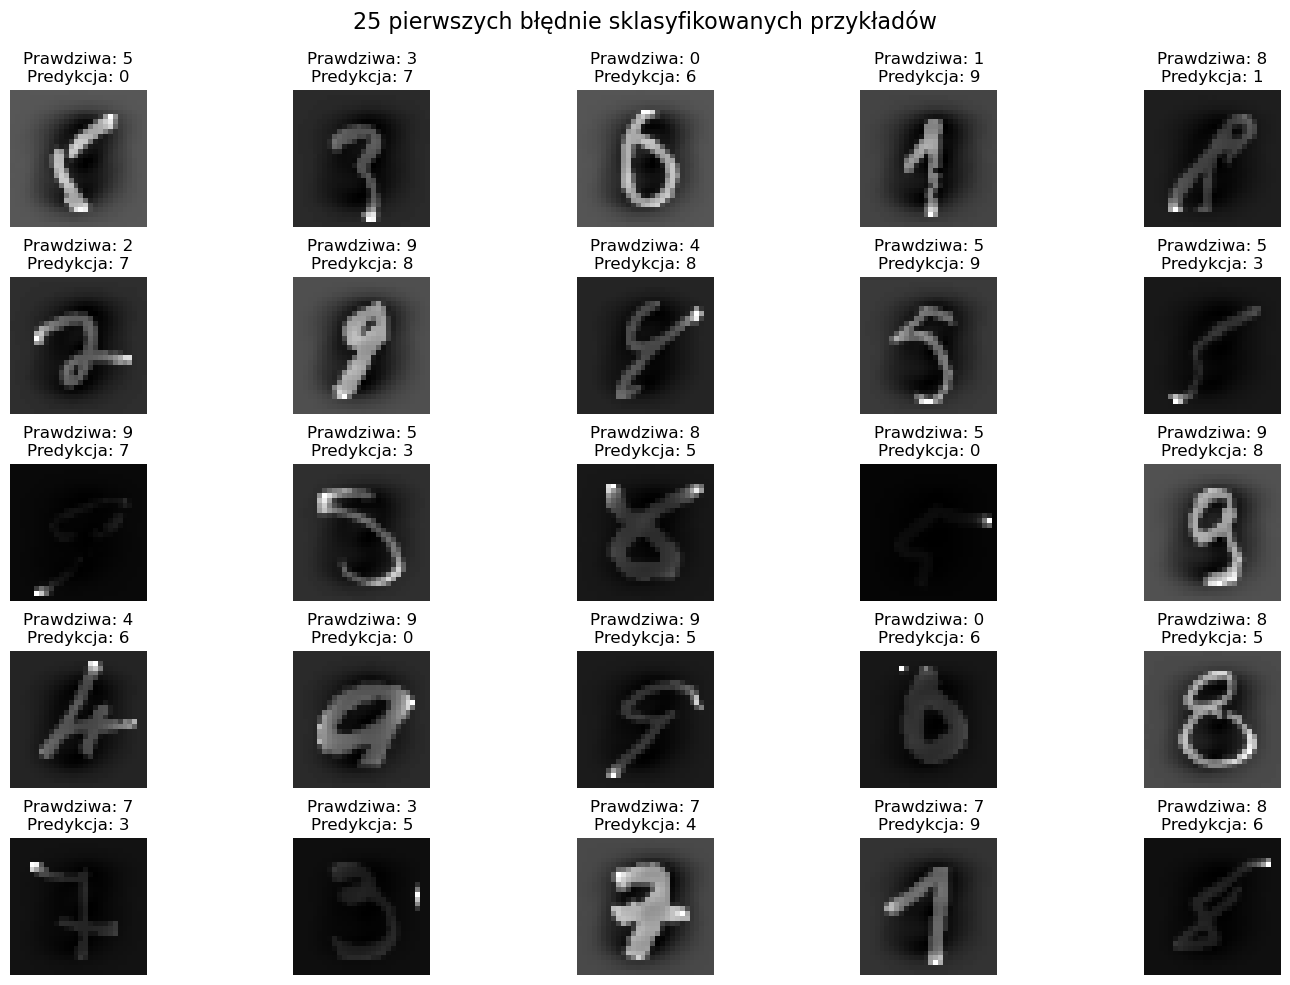

In [20]:
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices):
    if i >= 25:  # Wyświetl tylko 25 przykładów
        break
        
    plt.subplot(5, 5, i + 1)
    img = X_test[idx].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.title(f'Prawdziwa: {true_labels[i]}\nPredykcja: {predicted_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.suptitle("25 pierwszych błędnie sklasyfikowanych przykładów", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()


## Zadanie 3.6*

Przetestować inne wartości parametru $\eta$ oraz inne liczby neuronów w warstwie ukrytej.


--- Eksperyment: η=0.01, neurony ukryte=20 ---
Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 27.94% | Valid Acc: 28.00%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 33.98% | Valid Acc: 34.20%
Epoch: 003/050 | Train MSE: 0.09 | Train Acc: 37.29% | Valid Acc: 37.68%
Epoch: 004/050 | Train MSE: 0.08 | Train Acc: 39.91% | Valid Acc: 39.92%
Epoch: 005/050 | Train MSE: 0.08 | Train Acc: 42.82% | Valid Acc: 42.92%
Epoch: 006/050 | Train MSE: 0.08 | Train Acc: 45.53% | Valid Acc: 45.94%
Epoch: 007/050 | Train MSE: 0.08 | Train Acc: 48.26% | Valid Acc: 48.08%
Epoch: 008/050 | Train MSE: 0.07 | Train Acc: 51.06% | Valid Acc: 50.94%
Epoch: 009/050 | Train MSE: 0.07 | Train Acc: 53.92% | Valid Acc: 53.46%
Epoch: 010/050 | Train MSE: 0.07 | Train Acc: 56.65% | Valid Acc: 56.54%
Epoch: 011/050 | Train MSE: 0.06 | Train Acc: 59.67% | Valid Acc: 58.82%
Epoch: 012/050 | Train MSE: 0.06 | Train Acc: 62.67% | Valid Acc: 62.14%
Epoch: 013/050 | Train MSE: 0.06 | Train Acc: 65.59% | Valid Acc: 64.64%
Epo

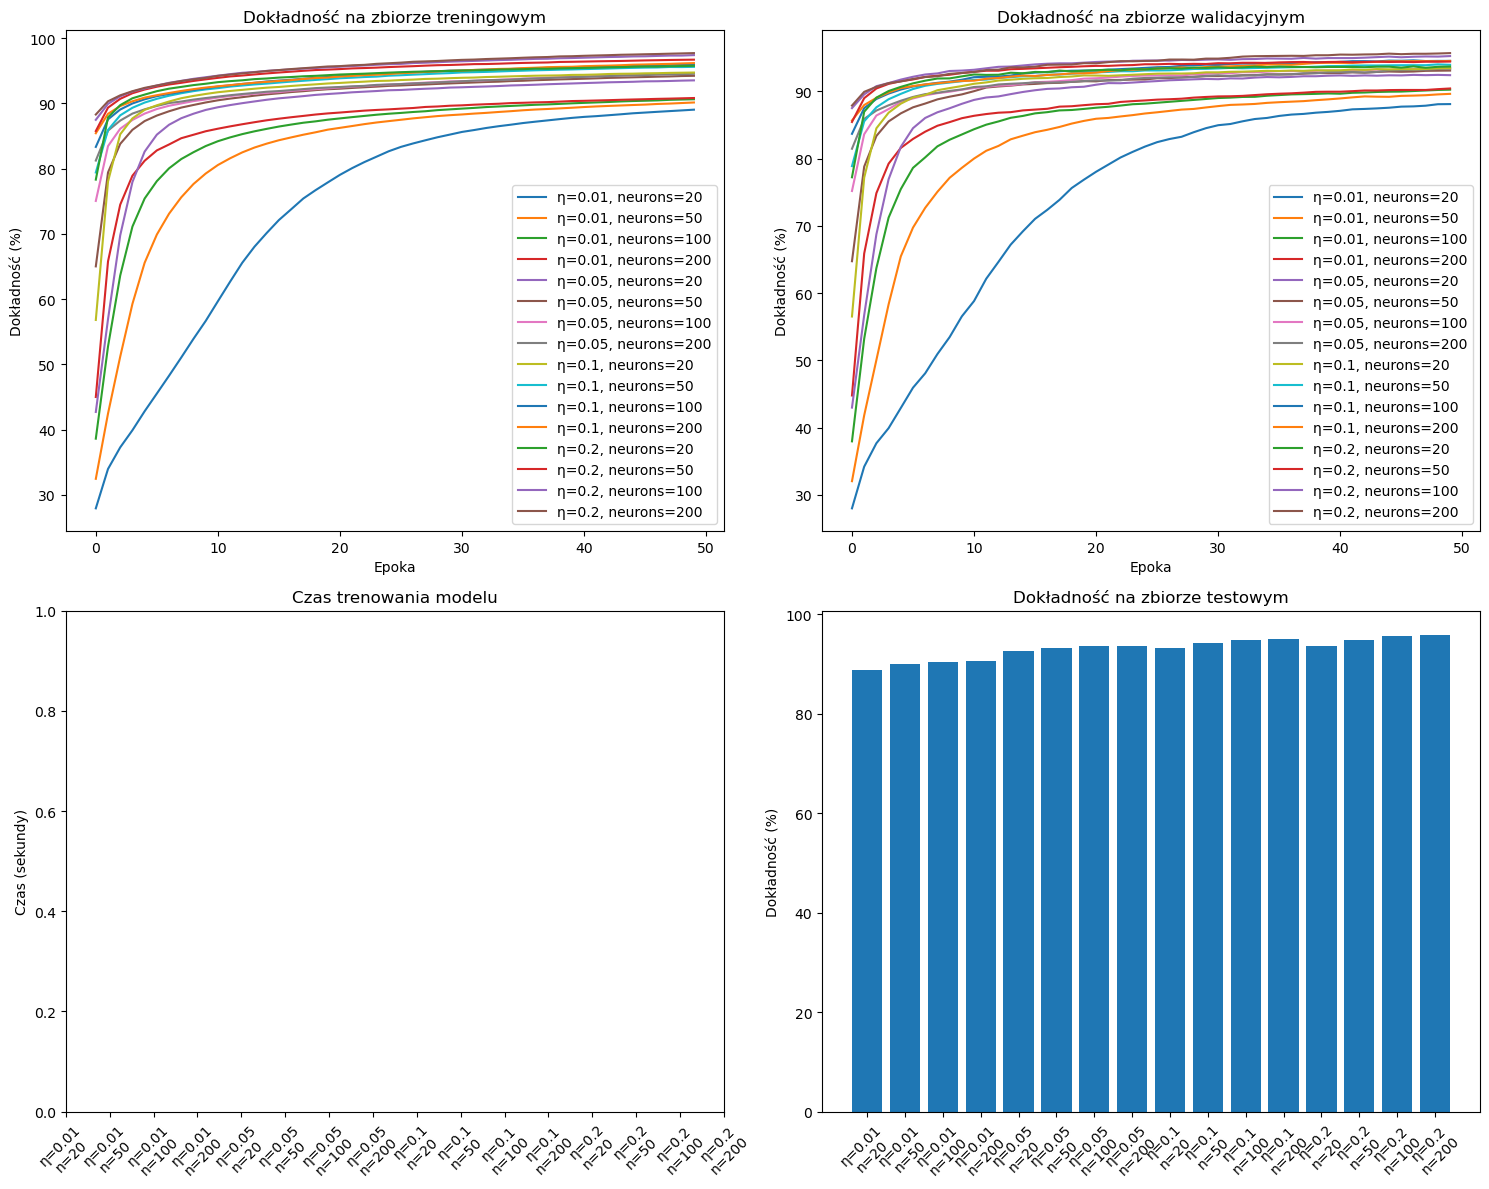


--- Podsumowanie wyników ---
η     | Neurony | Trening Acc  | Walidacja Acc  | Test Acc   | MSE Test   | Czas (s)  
--------------------------------------------------------------------------------
0.01  | 20      | 89.04        | 88.10          | 88.89      | 0.0233    
0.01  | 50      | 90.14        | 89.62          | 89.92      | 0.0189    
0.01  | 100     | 90.64        | 90.24          | 90.51      | 0.0177    
0.01  | 200     | 90.83        | 90.42          | 90.54      | 0.0172    
0.05  | 20      | 93.53        | 92.40          | 92.56      | 0.0128    
0.05  | 50      | 94.23        | 93.08          | 93.31      | 0.0113    
0.05  | 100     | 94.60        | 93.42          | 93.67      | 0.0109    
0.05  | 200     | 94.55        | 93.34          | 93.67      | 0.0111    
0.1   | 20      | 94.73        | 93.44          | 93.25      | 0.0113    
0.1   | 50      | 95.60        | 93.94          | 94.31      | 0.0097    
0.1   | 100     | 95.99        | 94.52          | 94.85      |

In [23]:
results = []
def run_experiment(learning_rate, hidden_neurons):
    print(f"\n--- Eksperyment: η={learning_rate}, neurony ukryte={hidden_neurons} ---")    
    model = NeuralNetMLP(num_features=num_features, 
                         num_hidden=hidden_neurons, 
                         num_classes=num_classes)
    
    train_losses, train_accuracies, val_accuracies = train(
        model, X_train, y_train, X_val, y_val, 
        num_epochs=num_epochs, 
        learning_rate=learning_rate,
        minibatch_size=minibatch_size)
    
    test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
    
    
    result = {
        'learning_rate': learning_rate,
        'hidden_neurons': hidden_neurons,
        'final_train_acc': train_accuracies[-1],
        'final_val_acc': val_accuracies[-1],
        'test_acc': test_acc * 100,
        'test_mse': test_mse,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }
    
    results.append(result)
    
    print(f"Dokładność na zbiorze testowym: {test_acc*100:.2f}%")
    print(f"MSE na zbiorze testowym: {test_mse:.4f}")
    return result

learning_rates = [0.01, 0.05, 0.1, 0.2]
hidden_neurons = [20, 50, 100, 200]
for lr in learning_rates:
    for hn in hidden_neurons:
        run_experiment(lr, hn)
    # Wizualizacja wyników
plt.figure(figsize=(15, 12))

# Wykres dokładności na zbiorze testowym dla różnych parametrów
plt.subplot(2, 2, 1)
for result in results:
    plt.plot(result['train_accuracies'], label=f"η={result['learning_rate']}, neurons={result['hidden_neurons']}")
plt.title('Dokładność na zbiorze treningowym')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()

plt.subplot(2, 2, 2)
for result in results:
    plt.plot(result['val_accuracies'], label=f"η={result['learning_rate']}, neurons={result['hidden_neurons']}")
plt.title('Dokładność na zbiorze walidacyjnym')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()

# Wykres czasu treningu dla różnych parametrów
plt.subplot(2, 2, 3)
x = np.arange(len(results))
plt.xticks(x, [f"η={r['learning_rate']}\nn={r['hidden_neurons']}" for r in results], rotation=45)
plt.title('Czas trenowania modelu')
plt.ylabel('Czas (sekundy)')

# Wykres końcowej dokładności na zbiorze testowym
plt.subplot(2, 2, 4)
plt.bar(x, [r['test_acc'] for r in results])
plt.xticks(x, [f"η={r['learning_rate']}\nn={r['hidden_neurons']}" for r in results], rotation=45)
plt.title('Dokładność na zbiorze testowym')
plt.ylabel('Dokładność (%)')

plt.tight_layout()
plt.show()
print("\n--- Podsumowanie wyników ---")
print(f"{'η':<5} | {'Neurony':<7} | {'Trening Acc':<12} | {'Walidacja Acc':<14} | {'Test Acc':<10} | {'MSE Test':<10} | {'Czas (s)':<10}")
print("-" * 80)
for r in results:
    print(f"{r['learning_rate']:<5} | {r['hidden_neurons']:<7} | {r['final_train_acc']:<12.2f} | {r['final_val_acc']:<14.2f} | {r['test_acc']:<10.2f} | {r['test_mse']:<10.4f}")


